In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import glob
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import re

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

#print versions
print('tensorflow version',tf.__version__)


path=os.getcwd()
print(path)

Number of replicas: 1
tensorflow version 2.4.1
C:\Users\jerryold\Desktop\homework2


In [2]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [3]:
def print_results(y_test, y_pred):
    print('Accuracy   : {:.5f}'.format(accuracy_score(y_pred , y_test))) 
    print('AUC        : {:.5f}'.format(roc_auc_score(y_test , y_pred)))
    print('Precision  : {:.5f}'.format(precision_score(y_test , y_pred)))
    print('Recall     : {:.5f}'.format(recall_score(y_test , y_pred)))
    print('F1         : {:.5f}'.format(f1_score(y_test , y_pred)))
    print('Confusion Matrix : \n', confusion_matrix(y_test, y_pred))

In [4]:
#Load Data
train_path = path+'/chest_xray/train'
val_path = path+'/chest_xray/val'
test_path = path+'/chest_xray/test'

In [5]:
train_files_original = glob.glob(train_path+'/*/*')
val_files_original = glob.glob(val_path+'/*/*')
test_files = glob.glob(test_path+'/*/*')

print('number of train samples across classes:', len(train_files_original))
print('number of val samples across classes:', len(val_files_original))
print('number of test samples across classes:', len(test_files))

number of train samples across classes: 5216
number of val samples across classes: 16
number of test samples across classes: 624


In [6]:
#Process Inputs-As you can see, there are only 16 samples in validation set (~0.3%), we would prefer to have a greater proportion of samples included in validation set. Let's create a 80:30 split between train and test
files = np.unique(train_files_original + val_files_original)
train_files, val_files = train_test_split(files, test_size=0.2, shuffle=True)

print('number of train samples:', len(train_files))
print('number of val samples:', len(val_files))

number of train samples: 4185
number of val samples: 1047


In [7]:
count_normal = len([x for x in train_files if 'NORMAL' in x])
count_pneumonia = len([x for x in train_files if 'PNEUMONIA' in x])

print('Count of NORMAL images in train:', count_normal)
print('Count of PNEUMONIA images in train:', count_pneumonia)

Count of NORMAL images in train: 1088
Count of PNEUMONIA images in train: 3097


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_files)

for f in train_list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\jerryold\\Desktop\\homework2/chest_xray/train\\PNEUMONIA\\person1550_bacteria_4051.jpeg'
b'C:\\Users\\jerryold\\Desktop\\homework2/chest_xray/train\\NORMAL\\IM-0394-0001.jpeg'
b'C:\\Users\\jerryold\\Desktop\\homework2/chest_xray/train\\NORMAL\\NORMAL2-IM-0537-0001.jpeg'
b'C:\\Users\\jerryold\\Desktop\\homework2/chest_xray/train\\PNEUMONIA\\person1120_virus_1845.jpeg'
b'C:\\Users\\jerryold\\Desktop\\homework2/chest_xray/train\\NORMAL\\NORMAL2-IM-0403-0001.jpeg'


In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [10]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(path + "/chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [11]:

#輸出第一張原圖的size/max/min/mean
originalimage=cv2.imread(train_files[1])
print("------------------------------size-----------------------------")
print("Original Image shape: ", originalimage.shape)
print("\n\n")
print("------------------------------max value-----------------------------")
print("Original Image max-axis=0: ", originalimage.max(axis=(0)))
print("Original Image max-axis=1: ", originalimage.max(axis=(1)))
print("Original Image max-axis=2: ", originalimage.max(axis=(2)))
print("\n\n")
print("------------------------------min value-----------------------------")
print("Original Image min-axis=0: ", originalimage.min(axis=(0)))
print("Original Image min-axis=1: ", originalimage.min(axis=(1)))
print("Original Image min-axis=2: ", originalimage.min(axis=(2)))
print("\n\n")
print("------------------------------mean value-----------------------------")
print("Original Image mean-axis=0: ", originalimage.mean(axis=(0)))
print("Original Image mean-axis=1: ", originalimage.mean(axis=(1)))
print("Original Image mean-axis=2: ", originalimage.mean(axis=(2)))



------------------------------size-----------------------------
Original Image shape:  (1333, 1666, 3)



------------------------------max value-----------------------------
Original Image max-axis=0:  [[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 ...
 [239 239 239]
 [244 244 244]
 [254 254 254]]
Original Image max-axis=1:  [[251 251 251]
 [253 253 253]
 [250 250 250]
 ...
 [233 233 233]
 [232 232 232]
 [232 232 232]]
Original Image max-axis=2:  [[  0   0   0 ... 231 242 251]
 [  0   0   0 ... 236 242 253]
 [  0   0   0 ... 236 241 250]
 ...
 [  0   0   0 ... 109 119 135]
 [  0   0   0 ... 109 119 134]
 [  0   0   0 ... 114 120 135]]



------------------------------min value-----------------------------
Original Image min-axis=0:  [[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 ...
 [107 107 107]
 [119 119 119]
 [133 133 133]]
Original Image min-axis=1:  [[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
Original Image min-axis=2:  [[  0   0   0 ... 231 242 251]
 [  0   0   0 

In [12]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [13]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [14]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
#輸出修改後第一張原圖的size/max/min/mean
for image, label in train_ds.take(1):
    print("------------------------------size-----------------------------")
    print("Process Image shape: ", image.numpy().shape)
    print("\n\n")
    print("------------------------------max value-----------------------------")
    print("Image max-axis=0: ", image.numpy().max(axis=(0)))
    print("Image max-axis=1: ", image.numpy().max(axis=(1)))
    print("Image max-axis=2: ", image.numpy().max(axis=(2)))
    print("\n\n")
    print("------------------------------min value-----------------------------")
    print("Image max-axis=0: ", image.numpy().min(axis=(0)))
    print("Image max-axis=1: ", image.numpy().min(axis=(1)))
    print("Image max-axis=2: ", image.numpy().min(axis=(2)))
    print("\n\n")
    print("------------------------------mean value-----------------------------")
    print("Image max-axis=0: ", image.numpy().mean(axis=(0)))
    print("Image max-axis=1: ", image.numpy().mean(axis=(1)))
    print("Image max-axis=2: ", image.numpy().mean(axis=(2)))
    #判斷label狀況
    print("\n\n")
    print("Label: ", label.numpy())
    

------------------------------size-----------------------------
Process Image shape:  (180, 180, 3)



------------------------------max value-----------------------------
Image max-axis=0:  [[0.36765504 0.36765504 0.36765504]
 [0.19189544 0.19189544 0.19189544]
 [0.22352219 0.22352219 0.22352219]
 [0.28161225 0.28161225 0.28161225]
 [0.3192157  0.3192157  0.3192157 ]
 [0.33003625 0.33003625 0.33003625]
 [0.34694263 0.34694263 0.34694263]
 [0.38836598 0.38836598 0.38836598]
 [0.39458975 0.39458975 0.39458975]
 [0.42501825 0.42501825 0.42501825]
 [1.         1.         1.        ]
 [0.99888915 0.99888915 0.99888915]
 [1.         1.         1.        ]
 [0.99405223 0.99405223 0.99405223]
 [0.99870735 0.99870735 0.99870735]
 [0.991968   0.991968   0.991968  ]
 [0.9972112  0.9972112  0.9972112 ]
 [0.57372546 0.57372546 0.57372546]
 [0.5857955  0.5857955  0.5857955 ]
 [0.58424854 0.58424854 0.58424854]
 [0.6193537  0.6193537  0.6193537 ]
 [0.6397386  0.6397386  0.6397386 ]
 [0.6376466  0.63

In [17]:
test_list_ds = tf.data.Dataset.list_files(str(path + '/chest_xray/test2/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [18]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [19]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [20]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

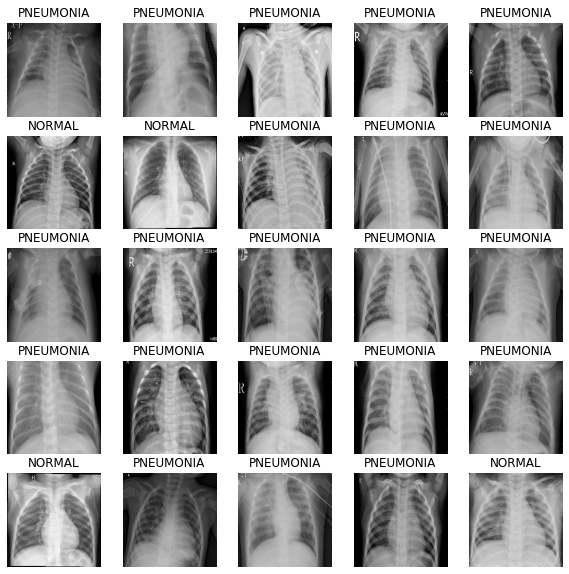

In [21]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [22]:
#Build CNN-The architecture for this CNN(block&dense layer)
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [23]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [25]:
#Correct for data imbalance
initial_bias = np.log([count_pneumonia/count_normal])
initial_bias


array([1.04609275])

In [26]:
weight_for_0 = (1 / count_normal)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / count_pneumonia)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.92
Weight for class 1: 0.68


In [27]:
#Train the model
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [29]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
32/32 [==============================] - 204s 6s/step - loss: 0.5518 - accuracy: 0.7024 - precision: 0.9219 - recall: 0.6588 - val_loss: 0.6351 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/25
32/32 [==============================] - 162s 5s/step - loss: 0.2599 - accuracy: 0.8955 - precision: 0.9800 - recall: 0.8777 - val_loss: 0.5612 - val_accuracy: 0.7520 - val_precision: 0.7520 - val_recall: 1.0000
Epoch 3/25
32/32 [==============================] - 165s 5s/step - loss: 0.1727 - accuracy: 0.9348 - precision: 0.9802 - recall: 0.9304 - val_loss: 0.6312 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 4/25
32/32 [==============================] - 157s 5s/step - loss: 0.1410 - accuracy: 0.9603 - precision: 0.9830 - recall: 0.9629 - val_loss: 0.7651 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 5/25
32/32 [==============================] - 179s 6s/step - loss: 0.1010 - accuracy: 0.9646 - precisi

In [30]:
# Finetune the model-checkpoint callback saves the best weights of the model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [31]:
#Finetune our learning rate
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [32]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
32/32 [==============================] - 153s 5s/step - loss: 0.2411 - accuracy: 0.9175 - precision: 0.9697 - recall: 0.9172 - val_loss: 10253.9004 - val_accuracy: 0.2520 - val_precision: 1.0000 - val_recall: 0.0013
Epoch 2/100
32/32 [==============================] - 153s 5s/step - loss: 0.1668 - accuracy: 0.9292 - precision: 0.9753 - recall: 0.9276 - val_loss: 680.6545 - val_accuracy: 0.2510 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 153s 5s/step - loss: 0.1397 - accuracy: 0.9475 - precision: 0.9792 - recall: 0.9492 - val_loss: 84.4696 - val_accuracy: 0.2510 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
32/32 [==============================] - 153s 5s/step - loss: 0.1086 - accuracy: 0.9565 - precision: 0.9870 - recall: 0.9538 - val_loss: 11.0417 - val_accuracy: 0.2783 - val_precision: 1.0000 - val_recall: 0.0390
Epoch 5/100
32/32 [==============================] - 157s 5s/step - loss: 0.0892

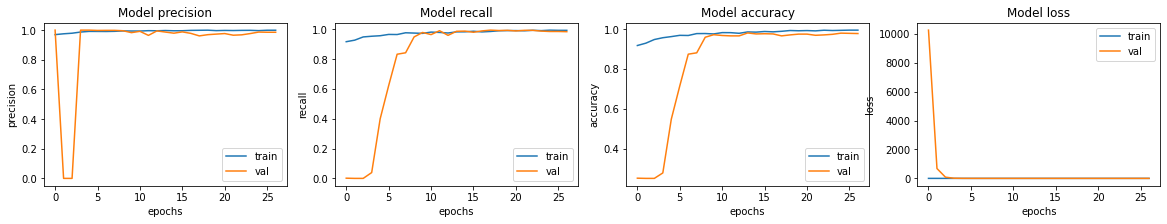

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
loss, acc, prec, rec = model.evaluate(test_ds)


5/5 [==============================] - 9s 1s/step - loss: 6.5521 - accuracy: 0.1170 - precision: 0.0000e+00 - recall: 0.0000e+00


In [35]:
print(prec)

0.0
